In [1]:
###################################################
### This file is part of numsimqubits.          ###
###                                             ###    
### Copyright (c) 2020 and later, Andras Gyenis ###
### All rights reserved.                        ###
###################################################

# Importing packages, modules.

import sys
import numpy as np
sys.path.append('../')

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, Image, Markdown

import numsimqubits.dynamics as dyn
from numsimqubits.dynamics.driven_systems import three_level_two_drive
from matplotlib.ticker import AutoMinorLocator
from qutip import Qobj
import qutip as qt

import numsimqubits.qubits.settings as sim_settings
sim_settings.update()

In [33]:
# Define drive object.
pulse_alpha = dyn.Gaussian_pulse(
                                t_0    = 400e-9,                   # The center of the pulse [s].
                                sigma  = 200e-9,                   # The width of the pulse [s].
                                amp    = 3.94e-3,                    # The amplitude of the pulse [GHz].
                                freq   = 4.996,                        # The frequency of drive [GHz] 
                                phase  = 0,                        # The phase of the pulse.
                                t_ls   = np.linspace(0, 0.8e-6, 201) # The time axis.  
                                )

pulse_beta = dyn.Gaussian_pulse(
                                t_0    = 400e-9,                   # The center of the pulse [s].
                                sigma  = 200e-9,                   # The width of the pulse [s].
                                amp    = 3.94e-3,                    # The amplitude of the pulse [GHz].
                                freq   = 2.996,                        # The frequency of drive [GHz] 
                                phase  = 0,                        # The phase of the pulse.
                                t_ls   = np.linspace(0, 0.8e-6, 201) # The time axis.  
                                )

# Define the lambda level system object.
three_level_system = dyn.Atom(
                              N_levels      = 3,               # The number of energy levels.
                              energies      = [0, 2, 5],          # The energy of the atomic levels [GHz].
                              couplings     = [[0, 0, 1],       # The couplings between energy elevels.
                                               [0, 0, 1],
                                               [1, 1, 0]], 
                              depolar_rates = [[0, 0, 0],    # The decay between energy levels [GHz]. 
                                               [1e-6/2/np.pi, 0, 0], 
                                               [5e-4/2/np.pi, 5e-4/2/np.pi, 0]], 
                              dephase_rates = [[0, 0, 0],      # The dephasing between energy levels [GHz].
                                               [0, 1e-4/2/np.pi, 0], 
                                               [0, 0, 1e-3/2/np.pi]],
                              initial_state = qt.basis(3,0)
                      )



### Calculate the dynamics

In [34]:
three_level_system.calculate_dynamics(three_level_two_drive, pulse_alpha, pulse_beta)

<IPython.core.display.Javascript object>


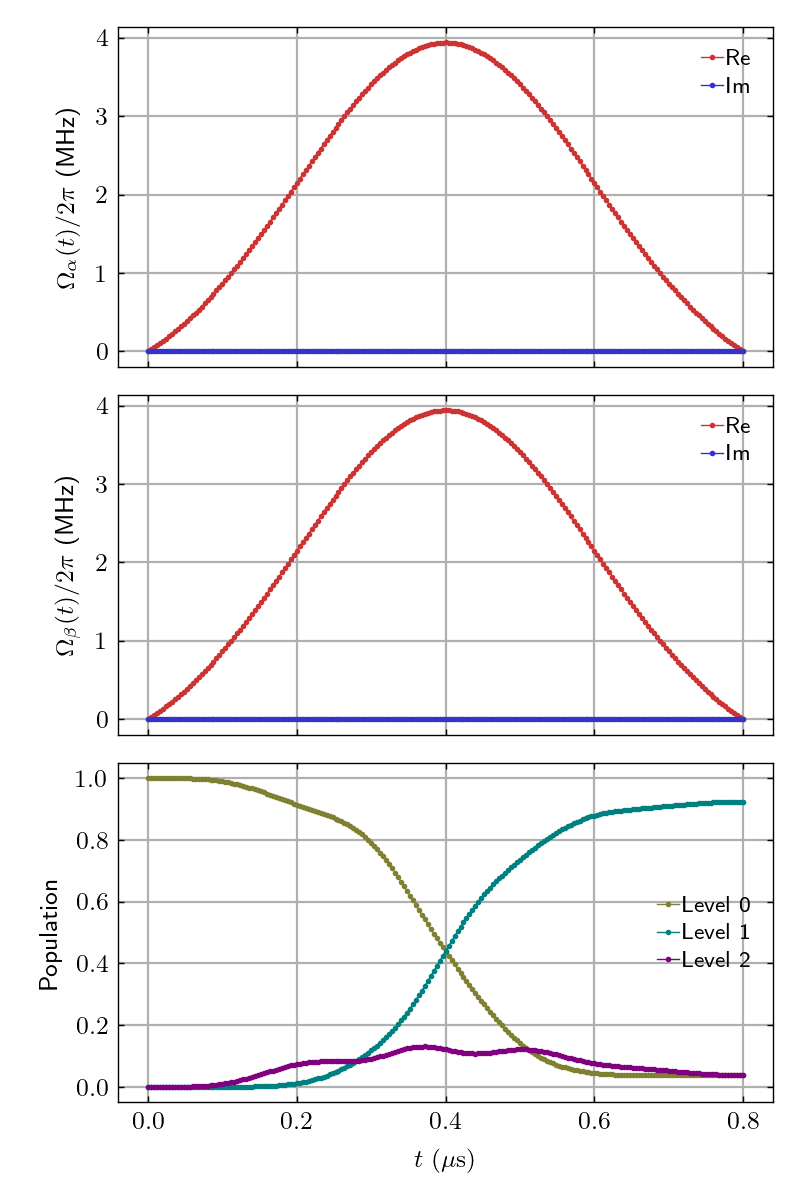

In [35]:
# Plot the pulses and the populations.

t_list = pulse_alpha.t_ls

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, 
                        gridspec_kw={'height_ratios':[1,1, 1]},
                       figsize=(4,6))

axs[0].plot(t_list * 1e6, pulse_alpha.I(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.8,0.2,0.2], label = r'Re')
axs[0].plot(t_list * 1e6, pulse_alpha.Q(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.2,0.2,0.8], label = r'Im')
axs[0].set_ylabel(r"$\Omega_\alpha(t)/2\pi$ (MHz)", labelpad=5)
axs[0].legend(loc='best', fontsize = 8)
axs[0].grid()

axs[1].plot(t_list * 1e6, pulse_beta.I(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.8,0.2,0.2], label = r'Re')
axs[1].plot(t_list * 1e6, pulse_beta.Q(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.2,0.2,0.8], label = r'Im')
axs[1].set_ylabel(r"$\Omega_\beta(t)/2\pi$ (MHz)", labelpad=5)
axs[1].legend(loc='best', fontsize = 8)
axs[1].grid()

axs[2].plot(t_list * 1e6, three_level_system.population[0], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.5,0.2], label = r'Level 0')

axs[2].plot(t_list * 1e6, three_level_system.population[1], '-o', markersize= 1, linewidth=0.5,
            color=[0.0,0.5,0.5], label = r'Level 1')

axs[2].plot(t_list * 1e6, three_level_system.population[2], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.0,0.5], label = r'Level 2')

axs[2].set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
axs[2].set_ylabel("Population", labelpad=5)
axs[2].legend(loc='best', fontsize = 8)
axs[2].grid()

plt.tight_layout()
plt.show()

In [37]:
three_level_system.population[1][-1]

0.9236825696191003

### Amplitude-Amplitude scan

In [13]:
amp_ls = np.linspace(1e-3, 11e-3, 21)
t_list = pulse_alpha.t_ls

detuning = -4e-3

pulse_alpha.t_0   = 400e-9 
pulse_alpha.sigma = 200e-9 
pulse_alpha.phase = 0 
pulse_alpha.freq  = three_level_system.energies[2] + detuning

pulse_beta.t_0    = 400e-9 
pulse_beta.sigma  = 200e-9 
pulse_beta.phase  = 0 
pulse_beta.freq   = three_level_system.energies[2] - three_level_system.energies[1] + detuning

population0_mx = np.zeros((len(amp_ls), len(amp_ls)))
population1_mx = np.zeros((len(amp_ls), len(amp_ls)))
population2_mx = np.zeros((len(amp_ls), len(amp_ls)))

for amp_alpha_idx, amp_alpha in enumerate(amp_ls):    
    for amp_beta_idx, amp_beta in enumerate(amp_ls):
        
        pulse_alpha.amp  = amp_alpha
        pulse_beta.amp   = amp_beta
        pulse_alpha.update_base()
        pulse_beta.update_base()
        
        three_level_system.calculate_dynamics(three_level_two_drive, pulse_alpha, pulse_beta)
        
        population0_mx[amp_alpha_idx, amp_beta_idx] = three_level_system.population[0][-1]
        population1_mx[amp_alpha_idx, amp_beta_idx] = three_level_system.population[1][-1]
        population2_mx[amp_alpha_idx, amp_beta_idx] = three_level_system.population[2][-1]





<IPython.core.display.Javascript object>


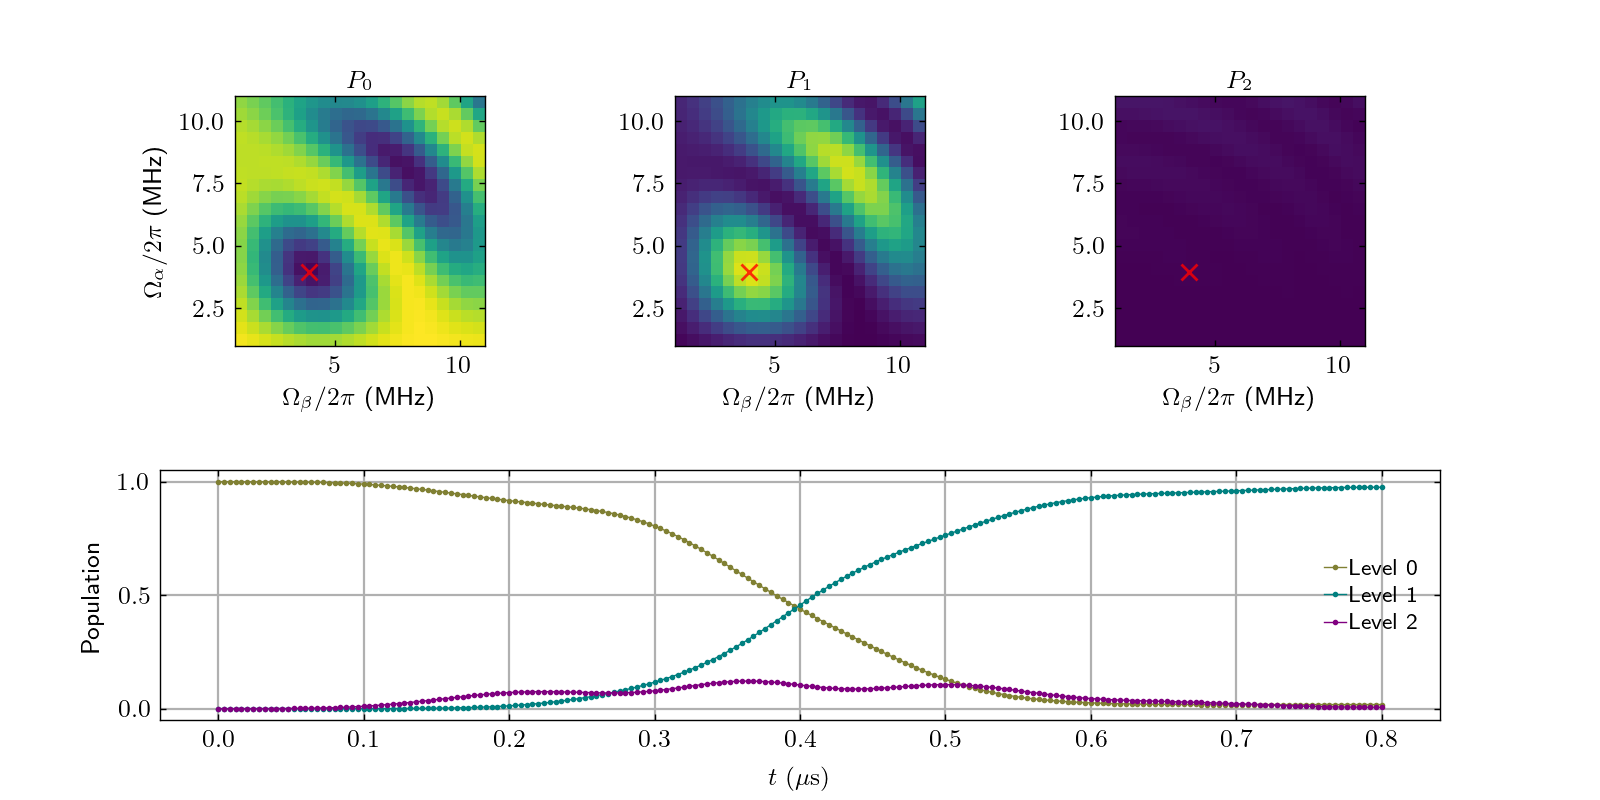

In [14]:
pulse_alpha.amp  = 3.95e-3
pulse_beta.amp   = 3.95e-3
pulse_alpha.update_base()
pulse_beta.update_base()

three_level_system.calculate_dynamics(three_level_two_drive, pulse_alpha, pulse_beta)

fig, axs = plt.subplots(figsize=(8,4), constrained_layout=False)

gs = GridSpec(2, 3, figure=fig,height_ratios=[1, 1],
              wspace = 0.1, hspace = 0.5, left = 0.1, right = 0.9, bottom = 0.1)

axs = []

axs.append(plt.subplot(gs[0,0]))
axs.append(plt.subplot(gs[0,1]))
axs.append(plt.subplot(gs[0,2]))
axs.append(plt.subplot(gs[1,:]))


axs[0].imshow(np.flipud(population0_mx), 
          extent=[amp_ls[0]*1e3, amp_ls[-1]*1e3, amp_ls[0]*1e3, amp_ls[-1]*1e3],
          aspect=1,vmin=0, vmax=1)
axs[0].plot(pulse_beta.amp*1e3, pulse_alpha.amp*1e3, 'rx', alpha=0.8)

axs[1].imshow(np.flipud(population1_mx), 
          extent=[amp_ls[0]*1e3, amp_ls[-1]*1e3, amp_ls[0]*1e3, amp_ls[-1]*1e3],
          aspect=1, vmin=0, vmax=1)
axs[1].plot(pulse_beta.amp*1e3, pulse_alpha.amp*1e3, 'rx', alpha=0.8)

axs[2].imshow(np.flipud(population2_mx), 
          extent=[amp_ls[0]*1e3, amp_ls[-1]*1e3, amp_ls[0]*1e3, amp_ls[-1]*1e3],
          aspect=1, vmin=0, vmax=1)
axs[2].plot(pulse_beta.amp*1e3, pulse_alpha.amp*1e3, 'rx', alpha=0.8)

axs[0].set_title(r"$P_0$")
axs[1].set_title(r"$P_1$")
axs[2].set_title(r"$P_2$")

axs[0].set_xlabel(r"$\Omega_\beta / 2\pi$ (MHz)")
axs[1].set_xlabel(r"$\Omega_\beta / 2\pi$ (MHz)")
axs[2].set_xlabel(r"$\Omega_\beta / 2\pi$ (MHz)")
axs[0].set_ylabel(r"$\Omega_\alpha / 2\pi$ (MHz)")

axs[3].plot(t_list * 1e6, three_level_system.population[0], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.5,0.2], label = r'Level 0')
axs[3].plot(t_list * 1e6, three_level_system.population[1], '-o', markersize= 1, linewidth=0.5,
            color=[0.0,0.5,0.5], label = r'Level 1')
axs[3].plot(t_list * 1e6, three_level_system.population[2], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.0,0.5], label = r'Level 2')

axs[3].set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
axs[3].set_ylabel("Population", labelpad=5)
axs[3].legend(loc='best', fontsize = 8)
axs[3].grid()


# cax = plt.axes([0.95, 0.25, 0.02, 0.15])
# cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
# cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

In [25]:
amp_ls = np.linspace(1e6, 101e6, 51)

detuning = 0e6

pulse_alpha.t_0   = 20e-9 
pulse_alpha.sigma = 10e-9 
pulse_alpha.phase = 0 
pulse_alpha.freq  = three_level_system.energies[2] + detuning

pulse_beta.t_0    = 20e-9 
pulse_beta.sigma  = 10e-9 
pulse_beta.phase  = 0 
pulse_beta.freq   = three_level_system.energies[2] - three_level_system.energies[1] + detuning

population0_mx = np.zeros((len(amp_ls), len(amp_ls)))
population1_mx = np.zeros((len(amp_ls), len(amp_ls)))
population2_mx = np.zeros((len(amp_ls), len(amp_ls)))

for amp_alpha_idx, amp_alpha in enumerate(amp_ls):    
    for amp_beta_idx, amp_beta in enumerate(amp_ls):
        
        pulse_alpha.amp  = amp_alpha
        pulse_beta.amp   = amp_beta
        
        density_matrices = calculate_dynamics(three_level_two_drive, t_list, initial_state, three_level_system, pulse_alpha, pulse_beta) 
        population       = get_population(density_matrices, three_level_system)
        
        population0_mx[amp_alpha_idx, amp_beta_idx] = population[0][-1]
        population1_mx[amp_alpha_idx, amp_beta_idx] = population[1][-1]
        population2_mx[amp_alpha_idx, amp_beta_idx] = population[2][-1]





<IPython.core.display.Javascript object>


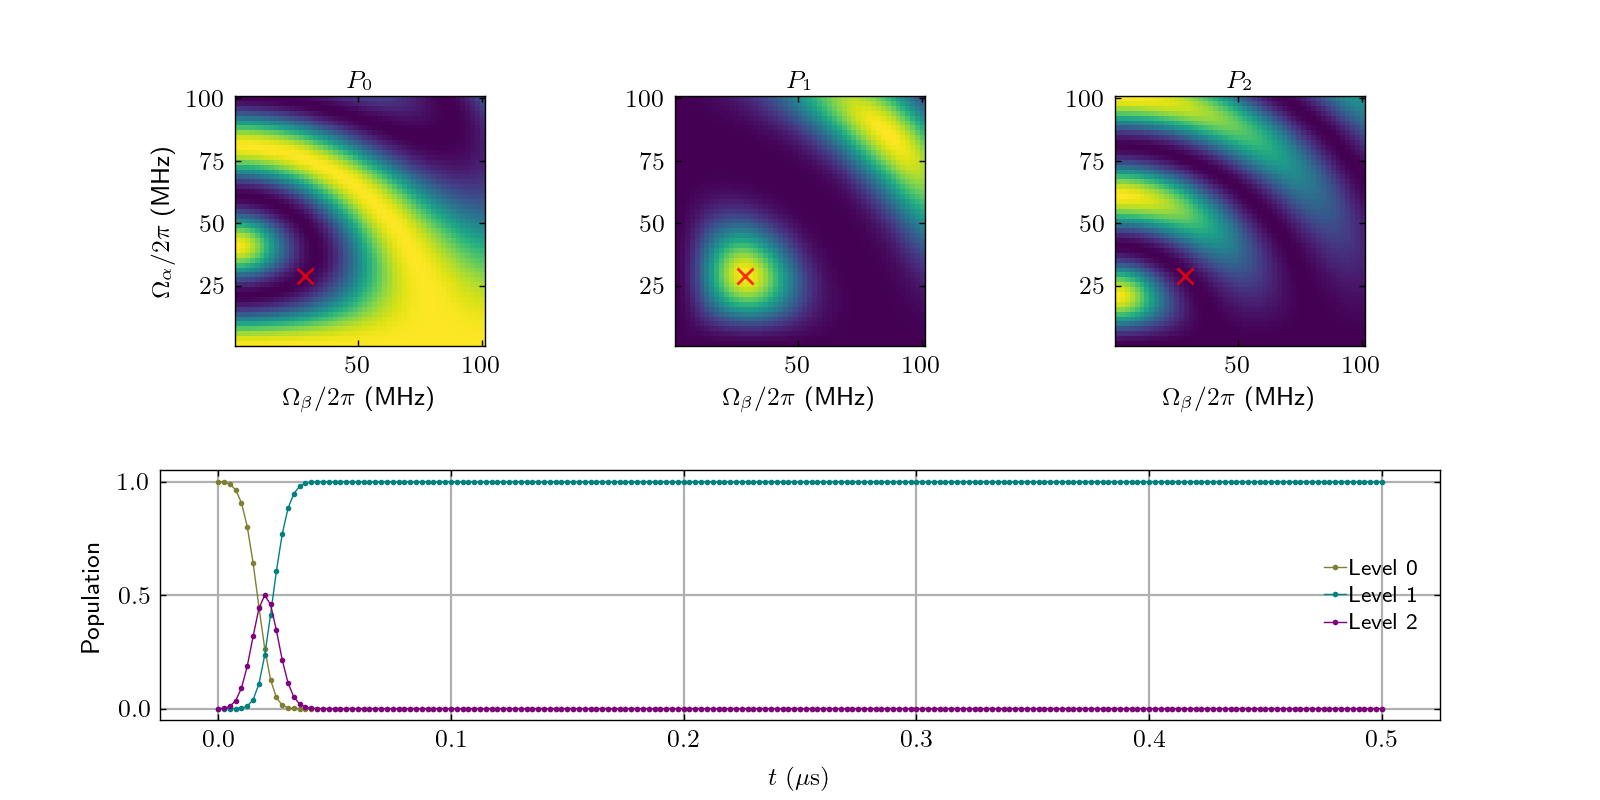

In [59]:
pulse_alpha.amp  = 29e6
pulse_beta.amp   = 29e6
density_matrices = calculate_dynamics(three_level_two_drive, t_list, initial_state, three_level_system, pulse_alpha, pulse_beta) 
population       = get_population(density_matrices, three_level_system)

fig, axs = plt.subplots(figsize=(8,4), constrained_layout=False)

gs = GridSpec(2, 3, figure=fig,height_ratios=[1, 1],
              wspace = 0.1, hspace = 0.5, left = 0.1, right = 0.9, bottom = 0.1)

axs = []

axs.append(plt.subplot(gs[0,0]))
axs.append(plt.subplot(gs[0,1]))
axs.append(plt.subplot(gs[0,2]))
axs.append(plt.subplot(gs[1,:]))


axs[0].imshow(np.flipud(population0_mx), 
          extent=[amp_ls[0]/1e6, amp_ls[-1]/1e6, amp_ls[0]/1e6, amp_ls[-1]/1e6],
          aspect=1,vmin=0, vmax=1)
axs[0].plot(pulse_beta.amp/1e6, pulse_alpha.amp/1e6, 'rx', alpha=0.8)

axs[1].imshow(np.flipud(population1_mx), 
          extent=[amp_ls[0]/1e6, amp_ls[-1]/1e6, amp_ls[0]/1e6, amp_ls[-1]/1e6],
          aspect=1, vmin=0, vmax=1)
axs[1].plot(pulse_beta.amp/1e6, pulse_alpha.amp/1e6, 'rx', alpha=0.8)

axs[2].imshow(np.flipud(population2_mx), 
          extent=[amp_ls[0]/1e6, amp_ls[-1]/1e6, amp_ls[0]/1e6, amp_ls[-1]/1e6],
          aspect=1, vmin=0, vmax=1)
axs[2].plot(pulse_beta.amp/1e6, pulse_alpha.amp/1e6, 'rx', alpha=0.8)

axs[0].set_title(r"$P_0$")
axs[1].set_title(r"$P_1$")
axs[2].set_title(r"$P_2$")

axs[0].set_xlabel(r"$\Omega_\beta / 2\pi$ (MHz)")
axs[1].set_xlabel(r"$\Omega_\beta / 2\pi$ (MHz)")
axs[2].set_xlabel(r"$\Omega_\beta / 2\pi$ (MHz)")
axs[0].set_ylabel(r"$\Omega_\alpha / 2\pi$ (MHz)")

axs[3].plot(t_list * 1e6, population[0], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.5,0.2], label = r'Level 0')
axs[3].plot(t_list * 1e6, population[1], '-o', markersize= 1, linewidth=0.5,
            color=[0.0,0.5,0.5], label = r'Level 1')
axs[3].plot(t_list * 1e6, population[2], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.0,0.5], label = r'Level 2')

axs[3].set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
axs[3].set_ylabel("Population", labelpad=5)
axs[3].legend(loc='best', fontsize = 8)
axs[3].grid()


# cax = plt.axes([0.95, 0.25, 0.02, 0.15])
# cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
# cb.set_label(r"$P_1$", labelpad=-5)


plt.show()